In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import defaultdict
from matplotlib.ticker import ScalarFormatter

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [59]:
file_path = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/plot_imem_data_ideal.npy' 
imem_data = np.load(file_path, allow_pickle=True).item()


In [60]:
# Make subset data dictionary for Im plots
target_freqs = [10, 100, 1000]

scatter_imem_data = {}

for cell_name, cell_data in imem_data.items():
    freqs = np.array(cell_data['freqs'])
    
    # Find indices corresponding to 10, 100, and 1000 Hz
    freq_indices = [np.argmin(np.abs(freqs - f)) for f in target_freqs]
    
    # Extract subsets
    imem_amps_subset = np.array(cell_data['imem_amps'])[:, freq_indices].tolist()
    imem_phases_subset = np.array(cell_data['imem_phases'])[:, freq_indices].tolist()
    pos_avg_subset = [cell_data['positive_avg_imem_pos'][i] for i in freq_indices]
    neg_avg_subset = [cell_data['negative_avg_imem_pos'][i] for i in freq_indices]
    cdm_pos_subset = [cell_data['cdm_pos'][i] for i in freq_indices]
    cdm_neg_subset = [cell_data['cdm_neg'][i] for i in freq_indices]
    
    # Build new dictionary for this cell
    scatter_imem_data[cell_name] = {
        'freqs': [freqs[i] for i in freq_indices],
        'x': cell_data['x'],
        'z': cell_data['z'],
        'totnsegs': cell_data['totnsegs'],
        'tvec': cell_data['tvec'],
        'imem_amps': imem_amps_subset,
        'imem_phases': imem_phases_subset,
        'cdm_pos': cdm_pos_subset,
        'cdm_neg': cdm_neg_subset
    }

In [71]:
def plot_imem_ideal(subset_imem_data, full_imem_data, xlim1 = (None, -0.002), xlim2 = (-4e-5, None)):
    left_cells = subset_imem_data
    right_cells = full_imem_data

    unique_cells = list(left_cells.keys())
    num_cells = len(unique_cells)
    if num_cells == 0:
        print("No cells to plot.")
        return

    # --- Figure setup ---
    fig = plt.figure(figsize=(10, 3 * num_cells))
    main_gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.8, 1], wspace=0.4)

    # --- LEFT PANEL (subset_imem_data with broken axis) ---
    gs_left = gridspec.GridSpecFromSubplotSpec(
        num_cells, 3, subplot_spec=main_gs[0, 0], width_ratios=[1, 1.2, 1.2], wspace=0.2, hspace=0.5
    )

    axs_left_panel = {}
    for i, label in enumerate(unique_cells):
        axs_left_panel[label] = {
            'morph': fig.add_subplot(gs_left[i, 0]),
            'imem_left': fig.add_subplot(gs_left[i, 1]),
            'imem_right': fig.add_subplot(gs_left[i, 2], sharey=fig.axes[-1] if i > 0 else None),
        }

    colors_neurons = ['salmon', 'deepskyblue']
    colors_pz = ['firebrick', 'darkblue']

    # ==================  MAIN LOOP OVER CELLS ===================================
    
    for i, (label, ax_dict) in enumerate(axs_left_panel.items()):

        # ---------------- Load cell data ----------------
        cell_data = left_cells[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        freqs = np.array(cell_data['freqs'])
        imem_amps = np.array(cell_data['imem_amps'])
        imem_phases = np.array(cell_data['imem_phases'])
        z_coords = z.mean(axis=-1)

        # ------------------------------------------------------------
        #                 A: MORPHOLOGY PLOT
        # ------------------------------------------------------------
        ax_morph = ax_dict['morph']
        color = colors_neurons[i % len(colors_neurons)]
        for idx in range(totnsegs):
            ax_morph.plot(x[idx], z[idx], c=color, lw=2)
        ax_morph.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', markersize=4)
        name = 'Long neuron' if 'BL_-500_UL_1000' in label else 'Short neuron'
        ax_morph.set_xlim(-np.max(z) * 0.3, np.max(z) * 0.3)
        ax_morph.set_title(name, fontsize=10, x=0.5, y=1.06)
        ax_morph.set_aspect('equal')
        ax_morph.set_xticks([])
        ax_morph.set_frame_on(False)

        

        # ------------------------------------------------------------
        #                B: SCATTER PLOTS WITH PHASE
        # ------------------------------------------------------------
        
        # Compute time of maximal inward soma Im 
        soma_amps = imem_amps[0]        # shape (3 freqs)
        soma_phases = imem_phases[0]

        t_max_dict = {}

        for f_idx, f in enumerate(freqs):
            A0 = soma_amps[f_idx]
            phi0 = soma_phases[f_idx]

            # time at the negative peak (inward Im)
            t_min = (3*np.pi/2 - phi0) / (2*np.pi*f)

            while t_min < 0:
                t_min += 1.0/f

            t_max_dict[f] = t_min

        ax_imem_left = ax_dict['imem_left']
        ax_imem_right = ax_dict['imem_right']
        colors_imem = ['tab:purple', 'tab:orange', 'tab:green']

        for f_idx, f in enumerate(freqs):

            chosen_t = t_max_dict[f]
            z_imem_map = defaultdict(float)

            # Compute instantaneous Im(t)
            for seg_idx in range(totnsegs):
                amp = imem_amps[seg_idx][f_idx]
                phi = imem_phases[seg_idx][f_idx]
                im_t = amp * np.sin(2*np.pi*f*chosen_t + phi)
                z_imem_map[z_coords[seg_idx]] += im_t

            z_vals = list(z_imem_map.keys())
            im_vals = list(z_imem_map.values())

            # keep your marker rules
            marker, markersize, alpha = (
                ('o', 25, 1) if f == 10 else
                ('x', 10, 1) if f == 100 else
                ('^', 10, 1)
            )

            ax_imem_left.scatter(im_vals, z_vals,
                                 color=colors_imem[f_idx],
                                 alpha=alpha,
                                 marker=marker,
                                 s=markersize)

            ax_imem_right.scatter(im_vals, z_vals,
                                  color=colors_imem[f_idx],
                                  alpha=alpha,
                                  marker=marker,
                                  s=markersize,
                                  label=f'{int(f)} Hz')

        ax_imem_right.axvline(0, color = 'black', linestyle = ':')

        # ------------------AXIS FORMATTING------------------------
        ax_imem_left.set_xlim(xlim1)
        ax_imem_right.set_xlim(xlim2)

        # Left 
        ax_imem_left.spines['right'].set_visible(False)
        ax_imem_left.yaxis.tick_left()
        ax_imem_left.set_ylabel('z [µm]')
        ax_imem_left.tick_params(labelleft=True)

        fmt_left = ScalarFormatter(useMathText=True)
        fmt_left.set_powerlimits((-2, 2))
        ax_imem_left.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))
        ax_imem_left.xaxis.set_major_formatter(fmt_left)

        # Right
        ax_imem_right.spines['left'].set_visible(False)
        ax_imem_right.yaxis.set_visible(False)
        ax_imem_right.yaxis.set_label_position('right')

        fmt_right = ScalarFormatter(useMathText=True)
        fmt_right.set_powerlimits((-2, 2))
        ax_imem_right.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))
        ax_imem_right.xaxis.set_major_formatter(fmt_right)

        # Diagonal break markers
        d = .015
        kwargs = dict(transform=ax_imem_left.transAxes, color='k', clip_on=False)
        ax_imem_left.plot((1 - d, 1 + d), (-d, +d), **kwargs)
        ax_imem_left.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

        kwargs.update(transform=ax_imem_right.transAxes)
        ax_imem_right.plot((-d, +d), (-d, +d), **kwargs)
        ax_imem_right.plot((-d, +d), (1 - d, 1 + d), **kwargs)

        if i == 0:
            ax_imem_right.legend(loc='best', fontsize='small')

    # Shared x-label
    fig.text(0.4, -0.0, '$I_\\mathrm{m}(t=t_{\\min})$ [nA]', ha='center', fontsize=10)

    # ------------------------------------------------------------
    #              C: AVG IMEM POSSITION
    # ------------------------------------------------------------
    gs_right = gridspec.GridSpecFromSubplotSpec(
        num_cells, 1, subplot_spec=main_gs[0, 1], hspace=0.5
    )

    for i, label in enumerate(unique_cells):
        ax = fig.add_subplot(gs_right[i, 0])
        cell_data = right_cells[label]

        freqs = np.array(cell_data['freqs'])
        pos_avg = np.array(cell_data['positive_avg_imem_pos'])
        neg_avg = np.array(cell_data['negative_avg_imem_pos'])

        name = 'Long neuron' if 'BL_-500_UL_1000' in label else 'Short neuron'
        color = colors_neurons[0] if 'Long' in name else colors_neurons[1]

        ax.axhline(0, color = 'tab:gray', linestyle = ':')

        ax.plot(freqs, pos_avg, 'o-', color=color, label='$\\lambda_\\mathrm{AC}$ Above', markersize=4)
        ax.plot(freqs, neg_avg, 'x--', color=color, label='$\\lambda_\\mathrm{AC}$ Below', markersize=4)

        ax.set_xscale('log')
        ax.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
        ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.8)
        #ax.grid(True, ls='--', alpha=0.6)
        lam_ylim = 1.1* max(np.max(pos_avg), np.max(np.abs(neg_avg)))
        ax.set_ylim(-lam_ylim, lam_ylim)
        ax.set_title(name, fontsize=10)
        ax.set_ylabel('$\\lambda_\\mathrm{AC}$ [µm]', fontsize=11, color=colors_neurons[i])
        #ax.legend(fontsize='x-small', loc='best')
        ax.tick_params(axis='y', labelcolor=colors_neurons[i])

        ax2 = ax.twinx()

        cdm_pos = np.array(cell_data['cdm_pos'])
        cdm_neg = np.array(cell_data['cdm_neg'])

        ax2.plot(freqs, cdm_pos, 'o-', color=colors_pz[i], label='$p_z$ Above', markersize=4)
        ax2.plot(freqs, -cdm_neg, 'x--', color=colors_pz[i], label='$p_z$ Below', markersize=4)

        ax2.set_ylabel('$p_z$ [µm]', fontsize=11, color=colors_pz[i])
        ax2.tick_params(axis='y', labelcolor=colors_pz[i])
        cdm_ylim = 1.1* max(np.max(cdm_pos), np.max(cdm_neg))
        ax2.set_ylim(-cdm_ylim, cdm_ylim)
        #ax2.legend(fontsize='x-small', loc='best')

        # ==== Combined legend for both axes ====
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        combined_lines = lines1 + lines2
        combined_labels = labels1 + labels2

        ax.legend(
            combined_lines,
            combined_labels,
            fontsize=7,
            loc='best',
            frameon=True,
            ncol = 2,
        )

        

    fig.text(0.77, -0.0, 'Frequency (Hz)', ha='center', fontsize=10)

    # ===== Panel labels =====
    fig.text(0.1, 0.96, 'A', fontsize=12, fontweight='bold')
    fig.text(0.21, 0.96, 'B', fontsize=12, fontweight='bold')
    fig.text(0.62, 0.96, 'C', fontsize=12, fontweight='bold')

    fig.savefig("/Users/susannedahle/Documents/Master/Code/fig_pdfs/imem/fig5.pdf")
    plt.show()


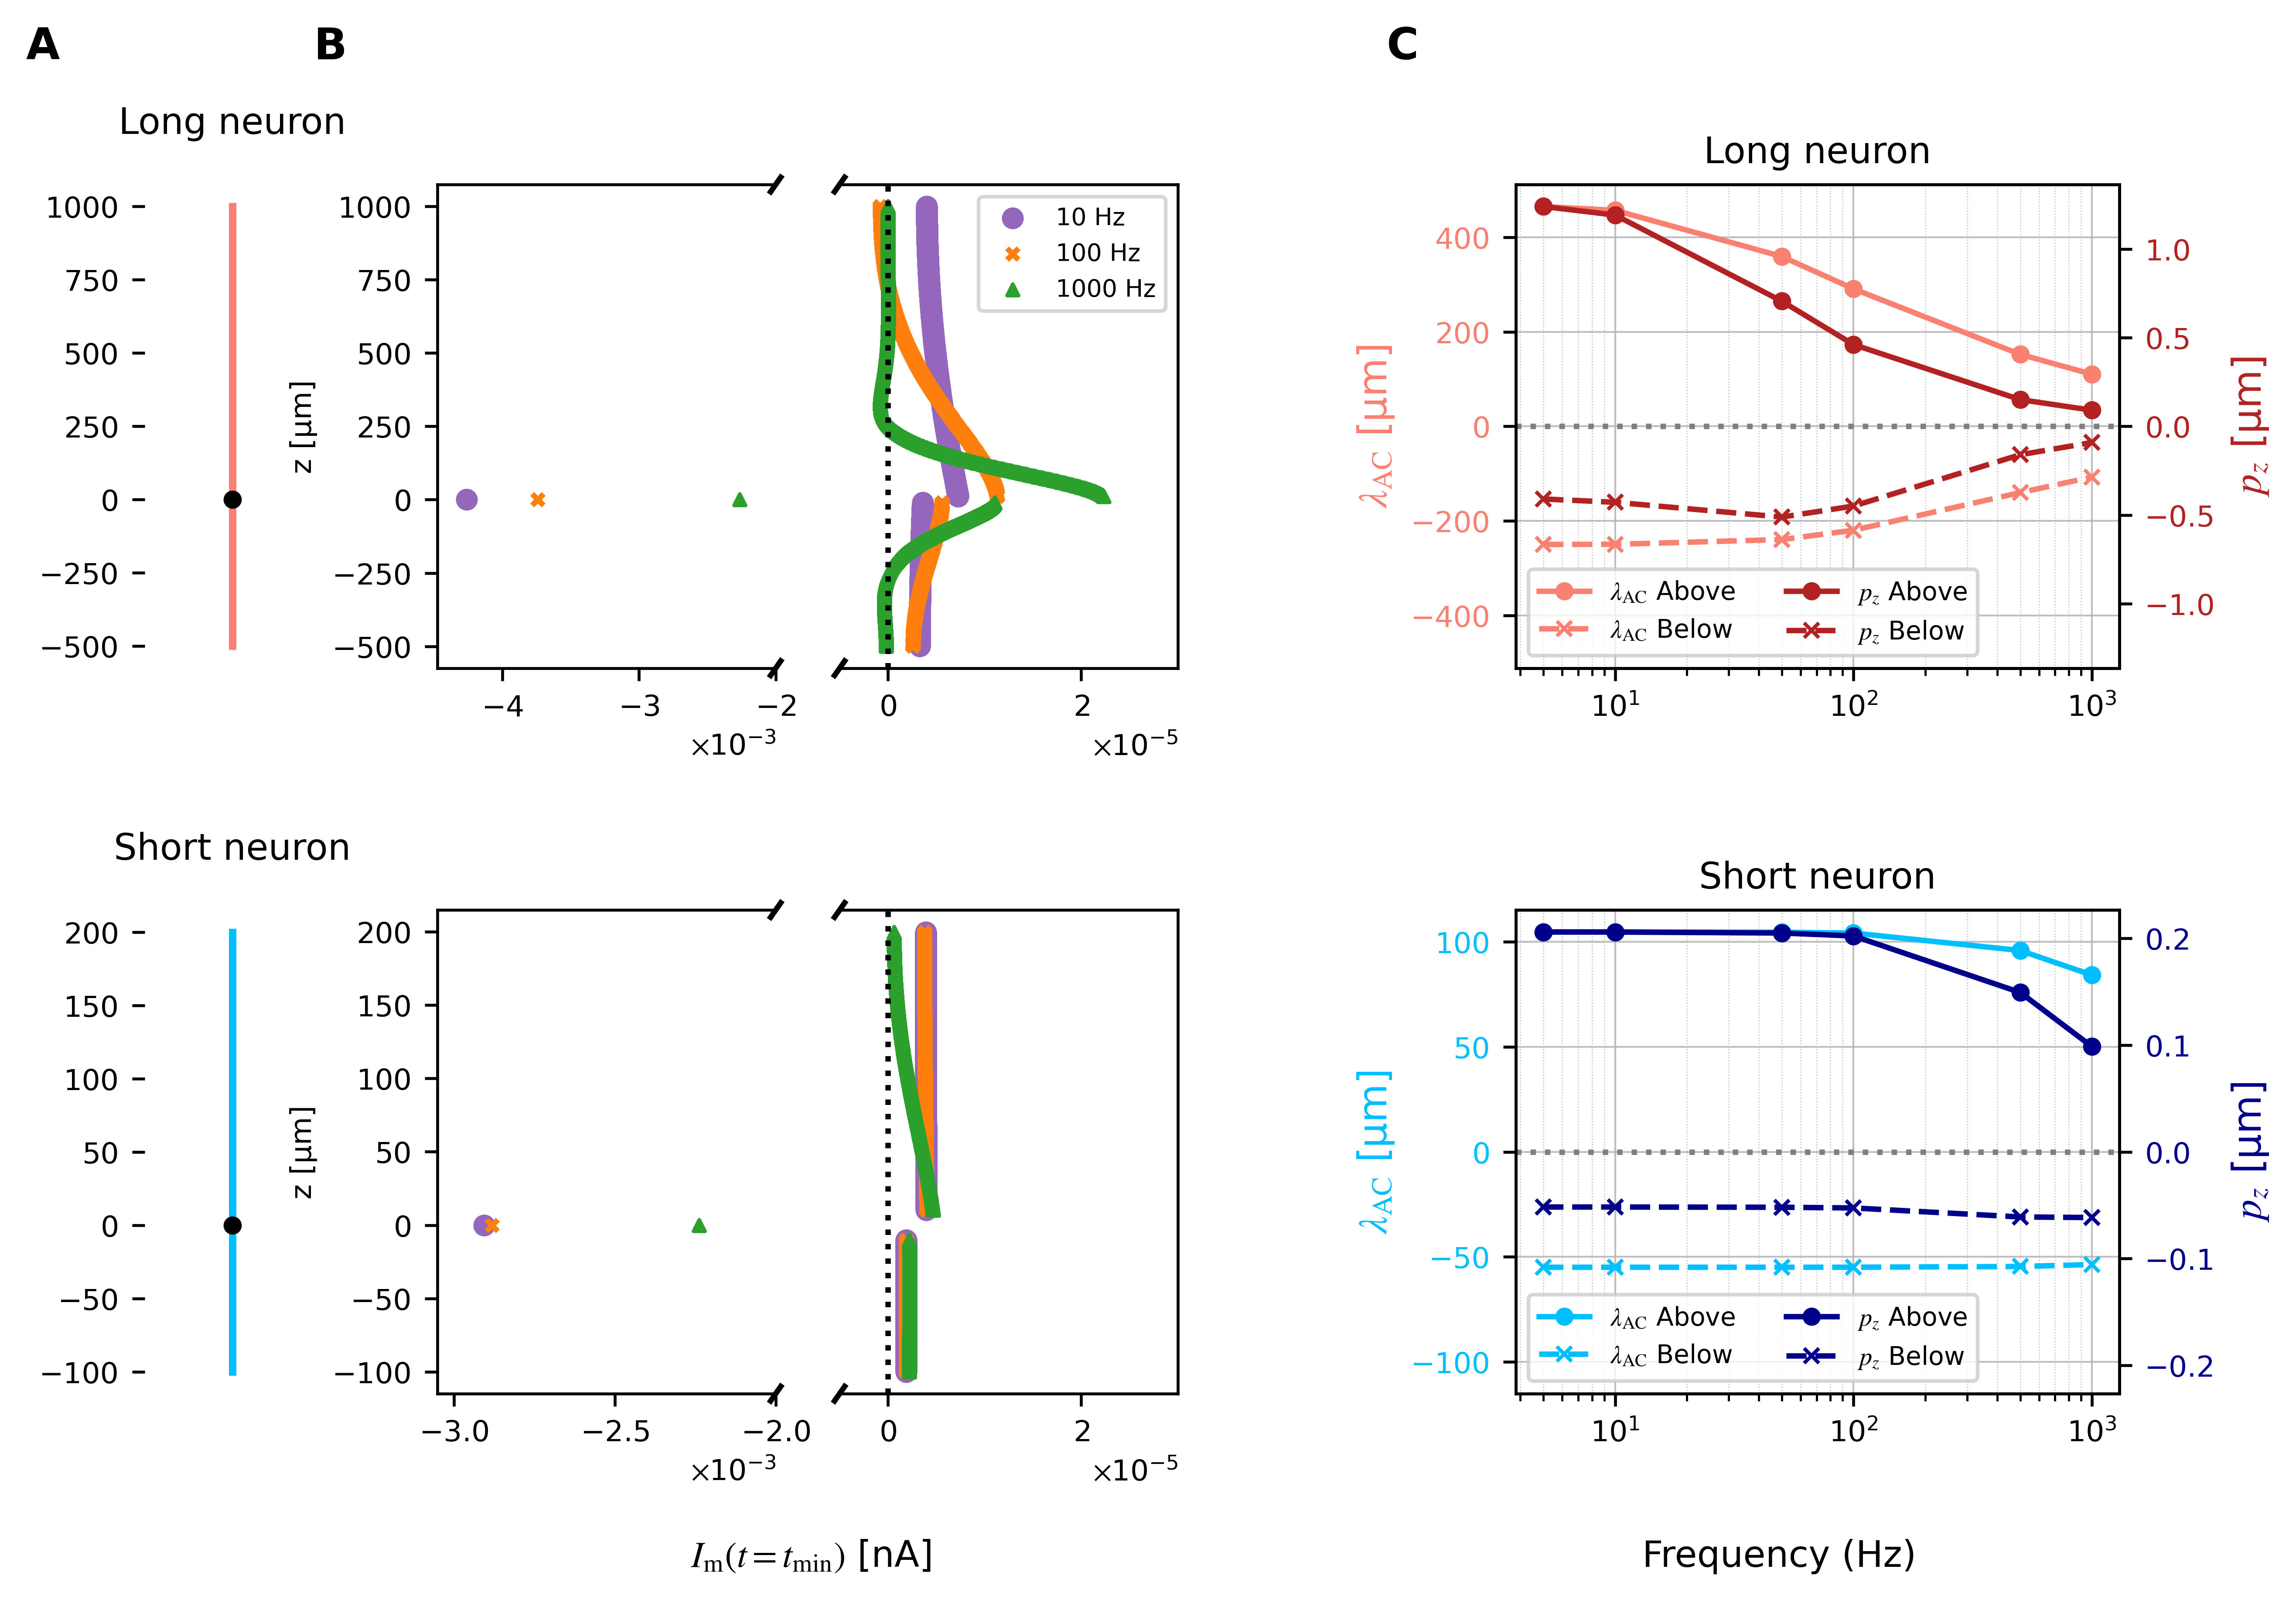

In [72]:
plot_imem_ideal(scatter_imem_data, imem_data, xlim1 = (None, -0.002), xlim2 = (-5e-6, 3e-5))